# KOSMA-$\tau^3$

This is a working notebook to run and debug the PDR synthetic observation software KOSMA-$\tau^3$.

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib widget

In [2]:
import os
import sys
import inspect
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

pathname = inspect.getframeinfo(inspect.currentframe()).filename
sys.path.append(os.path.abspath(os.path.dirname(pathname))+'/classes/')

from Model import *
import constants

The model parameters are set in this cell, with different flags available to limit the scope of model execution.

 - [x] **modelFlag**: Setup and evaluate the model emission for each voxel
 - [x] **rtFlag**: Evaluate the synthetic observation for a predefined number of sightlines
 - [ ] **cyplotFlag**: Re-grid the sightlines using `cygrid` and plot the map
 
 - **x,y,z**: overall size of model
 - **shape**: all fit within given dimensions
   - [x] block
   - [x] disk
   - [x] ellipsoid
   - [ ] shell
 - **resolution**: in parsecs
 - **focus**: how to limit the evaluated continuum wavelengths
   - `molecular`
     - $ \lambda_\mathrm{dust} > 10^{-4}m $
     - *23 points*
   - `PAH`
     - $ \lambda_\mathrm{dust} > 5 * 10^{-6}m $
     - *202 points*
   - `all`
     - *333 points*
 - **modelFolder**: needed when not running the full model; the directory of the model in `$ KOSMA-tau^3/history/`

In [3]:
import sys

sys.path.insert(1, "/home/craig/projects/pdr/")

import spectrum

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                   45                                                  
NAXIS2  =                   50                                                  
NAXIS3  =                   50                                                  
NAXIS4  =                   89                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
BUNIT   = 'K       '                                                            
CTYPE1  = 'Wavelength'                                                          
CUNIT1  = 'm       '                                                            
CRVAL1  = 'N/A     '        

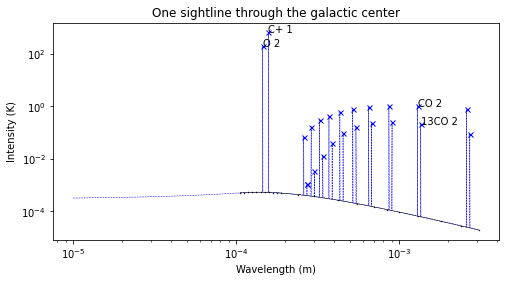

In [4]:
spectrum.spectrum(lon=25, lat=25, PAH=False)

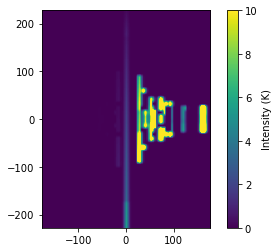

In [5]:
spectrum.PVdiagram()

In [4]:
complete = False

modelFlag = True
rtFlag = True
plotFlag = True
cyplotFlag = True

x = 36
y = 36
z = 2

shape = 'disk'

resolution = 1000

focus = 'molecular'

constants.changeDirectory('MilkyWay')

modelFolder = 'r1000_n3015/'

# Factors
constants.clumpMassFactor = 1
constants.interclumpMassFactor = 1
constants.FUVFactor = 1
constants.DensityFactor = 1

# Constant
constants.interclumpLogFUV = 1

# Model masses
constants.clumpLogMassNum = 4
constants.clumpLogMassRange = [-1, 2]
constants.interclumpLogMassNum = 2
constants.interclumpLogMassRange = [-3, -2]

In [5]:
# Limit dust calculation

print('KOSMA-tau^3')

species = ['13CO 10', 'C+ 1', 'CO 1', 'CO 2', 'CO 3', 'CO 4', 'CO 5', 'CO 6', 'CO 7', 'CO 8', 'CO 9', 'CO 10', '13CO 1', '13CO 2', '13CO 3', '13CO 4', '13CO 5', '13CO 6', '13CO 7', '13CO 8', '13CO 9', '13CO 10', 'O 2']
kosma = Model(x, y, z, modelType=shape, resolution=resolution, dustLim=focus)
kosma.addSpecies(species)

KOSMA-tau^3


## Setup

In [6]:
if modelFlag:

  kosma.calculateModel()
  kosma.writeEmission()
  
  modelFolder = constants.history

Voxels initialised:   0%|          | 0/3015 [00:00<?, ?it/s]


Calculating Grid Emission...


Voxels initialised: 100%|██████████| 3015/3015 [03:54<00:00, 12.88it/s]



Emission calculated successfully.

Streaming to fits files...


Voxel emissions: 100%|██████████| 3015/3015 [02:48<00:00, 17.84it/s]


Data files have been written successfully.



## Radiative transfer

In [6]:
# Calculate integrated intensity maps

if rtFlag:

  import radiativeTransfer

  # radiativeTransfer.plotModel(plot='velocity', directory='r1000.0_n3015/')

  radiativeTransfer.calculateObservation(directory=modelFolder, dim='spherical', terminal=False)

Observing velocity:  88%|████████▊ | 107/121 [03:37<00:08,  1.65it/s]

### Plot intensity map

In [7]:
if plotFlag:

  pos = fits.open('/home/craig/projects/pdr/KOSMA-tau^3/history/MilkyWay/r1000_n3015/integrated_intensity.fits')[0]    
  intensity = fits.open('/home/craig/projects/pdr/KOSMA-tau^3/history/MilkyWay/r1000_n3015/integrated_intensity.fits')[1]

  velocity = np.linspace(intensity.header['CRVAL4']-intensity.header['CRPIX4']*intensity.header['CDELT4'], intensity.header['CRVAL4']+intensity.header['CRPIX4']*intensity.header['CDELT4'], num=intensity.header['NAXIS4'])
  intensity_integrated = np.trapz(intensity.data, velocity, axis=0)

  if False:

    for i in range(intensity.data[:,0,0,0].size):

#       plt.close()
      
      proj = 'Galactic intensity map'
      fig = plt.figure(figsize=(10,10))
      ax = fig.add_subplot(111, projection='mollweide')

      # aspect = 20
      # pad_fraction = 0.5
      # divider = make_axes_locatable(ax)
      # width = axes_size.AxesY(ax, aspect=1./aspect)
      # pad = axes_size.Fraction(pad_fraction, width)
      # cax = divider.append_axes("right", size=width, pad=pad)

  #     cm = ax.scatter(pos.data[:,0], pos.data[:,1], c=intensity_integrated[:,:,23].flatten(), cmap='cubehelix', s=500, alpha = 0.5, marker='s')
      cm = ax.scatter(pos.data[:,0], pos.data[:,1], c=intensity.data[i,:,:,23].flatten(), cmap='cubehelix', s=64, alpha = 0.5, marker='s')
      cb = fig.colorbar(cm, extend='both', ax=ax, fraction = 0.02, )
      cb.ax.set_ylabel('Intensity (K km/s)', fontsize=20, labelpad=20, rotation=270)
  
  else:
    
    proj = 'Galactic intensity map'
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='mollweide')

    # aspect = 20
    # pad_fraction = 0.5
    # divider = make_axes_locatable(ax)
    # width = axes_size.AxesY(ax, aspect=1./aspect)
    # pad = axes_size.Fraction(pad_fraction, width)
    # cax = divider.append_axes("right", size=width, pad=pad)

#     cm = ax.imshow(intensity_integrated[:,:,23], cmap='cubehelix')
    cm = ax.scatter(pos.data[:,0], pos.data[:,1], c=intensity_integrated[:,:,23].flatten(), cmap='cubehelix', s=64, alpha = 0.5, marker='s')
    cb = fig.colorbar(cm, extend='both', ax=ax, fraction = 0.02, )
    cb.ax.set_ylabel('Intensity (K km/s)', fontsize=20, labelpad=20, rotation=270)

  ax.set_title(proj+r' $^{13}CO^{+}$', fontsize=24)
  ax.grid(True)
  ax.set_xticklabels([])
  ax.set_yticklabels([])

  plt.show()

In [8]:
intensity_integrated.shape

(50, 50, 45)

### Previous calculation

In [9]:
if plotFlag:
  plt.close()

  positions = fits.open('/home/craig/projects/pdr/KOSMA-tau^3/history/MilkyWay/r1000_n3015/voxel_position.fits')[0].data/1000.
  vel = fits.open('/home/craig/projects/pdr/KOSMA-tau^3/history/MilkyWay/r1000_n3015/voxel_velocity.fits')[0].data

  idx_plane = positions[:,2]==0
  idx_Earth = (np.sqrt(positions[:,0]**2+positions[:,1]**2)<=8.178) & (positions[:,0]>=0) & idx_plane

  idx = idx_Earth
  idx_obs = []

  for i in range(18,-19,-1):
      line = ''
      iy = i==positions[idx,1]
      orbit = True
      for j in range(18,-19,-1):
          ix = j==positions[idx,0]
          if (ix&iy).any() and orbit:
              line += 'XX'
              idx_obs.append(np.where(ix&iy)[0])
              orbit = False
          else: line += '--'
      #print(line)

  idx_obs = np.array(idx_obs)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  cm = ax.scatter(positions.T[0], positions.T[1], positions.T[2], c=vel[:,0], cmap='cubehelix', marker='s', s=27, alpha=0.5, linewidth=0)
  cb = fig.colorbar(cm)
  cb.ax.set_ylabel(r'Radial velocity ($\frac{km}{s}$)', labelpad=16, rotation=270)

  # lon,lat = np.meshgrid(np.linspace(-np.pi, np.pi, num=9), np.linspace(-np.pi/2, np.pi/2, num=5))
  # x = 10 * (np.cos(lat.flatten()) * np.cos(lon.flatten()))
  # y = 10 * (np.cos(lat.flatten()) * np.sin(lon.flatten()))
  # z = 10 * np.sin(lat.flatten())
  #print(idx_obs)
  ax.scatter(positions[idx,0][idx_obs], positions[idx,1][idx_obs], positions[idx,2][idx_obs], marker='o', s=49, c='b')
  ax.quiver(positions[idx,0][idx_obs], positions[idx,1][idx_obs], positions[idx,2][idx_obs], np.full_like(idx_obs, -24.178*np.sin(positions[idx,0][idx_obs]/8.178/2*np.pi)), 0,0, color='k')
  ax.quiver(positions[idx,0][idx_obs], positions[idx,1][idx_obs], positions[idx,2][idx_obs], np.full_like(idx_obs, 10), 0,0, color='k')

  ax.set_xlabel('X (kpc)')
  ax.set_ylabel('Y (kpc)')
  ax.set_zlabel('Z (kpc)')
  ax.set_xlim([-18, 18])
  ax.set_ylim([-18, 18])
  ax.set_zlim([-18, 18])
  plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Current desired calculation

In [10]:
if plotFlag:
  positions = fits.open('/home/craig/projects/pdr/KOSMA-tau^3/history/MilkyWay/r1000_n3015/voxel_position.fits')[0].data/1000.
  vel = fits.open('/home/craig/projects/pdr/KOSMA-tau^3/history/MilkyWay/r1000_n3015/voxel_velocity.fits')[0].data

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  cm = ax.scatter(positions.T[0], positions.T[1], positions.T[2], c=vel[:,0], cmap='cubehelix', marker='s', s=27, alpha=0.5, linewidth=0)
  cb = fig.colorbar(cm)
  cb.ax.set_ylabel(r'Radial velocity ($\frac{km}{s}$)', labelpad=16, rotation=270)

  lon,lat = np.meshgrid(np.linspace(-np.pi, np.pi, num=9), np.linspace(-np.pi/2, np.pi/2, num=5))
  x = 10 * (np.cos(lat.flatten()) * np.cos(lon.flatten()))
  y = 10 * (np.cos(lat.flatten()) * np.sin(lon.flatten()))
  z = 10 * np.sin(lat.flatten())

  ax.scatter([8.178], [0], [0], marker='o', s=49, c='b')
  ax.quiver(np.full_like(x, 8.178), np.full_like(x, 0), np.full_like(x, 0), x, y, z, color='k', arrow_length_ratio=0.2)

  ax.set_xlabel('X (kpc)')
  ax.set_ylabel('Y (kpc)')
  ax.set_zlabel('Z (kpc)')
  ax.set_xlim([-18, 18])
  ax.set_ylim([-18, 18])
  ax.set_zlim([-18, 18])
  plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Cygrid

In [11]:
%matplotlib widget
# Create cygrid images

if cyplotFlag:

  constants.mapShape = (200, 100)

  import cyplot
  
  modelFolder = 'r1000_n3015/'

  grid = cyplot.convertMap(modelFolder, input_coord='spherical')
  
  images = grid.get_datacube()
  wcs = grid.get_wcs()
  print(images.size, np.where(np.isnan(images))[0].size)

  images = np.nan_to_num(images)
  
  i = 0

  print(np.nanmin(images[i,:,:]), np.nanmax(images[i,:,:]))
  vmin = np.nanmin(images[i,:,:])
  vmax = np.nanmax(images[i,:,:])
  
  plt.close()

  fig = plt.figure()
  ax1 = fig.add_subplot(111, projection=wcs.celestial)
  dust = ax1.imshow(images[i,:,:], alpha=1, vmin=vmin, vmax=vmax, cmap='cubehelix')
  cbar1 = plt.colorbar(dust, ax=ax1, shrink=1)
  cbar1.ax.set_ylabel('Intensity (K km/s)', rotation=270)
#   i = 23
#   mol1 = ax1.imshow(image[i,:,:], alpha=0.5, cmap='magma')
#   cbar2 = plt.colorbar(mol1, ax=ax1, shrink=1)
#   cbar2.ax.set_ylabel('{} Intensity (K km/s)'.format(species[i-333]), rotation=270)
#   i = 44
#   mol2 = ax1.imshow(image[i,:,:], alpha=0.5, cmap='hot')
#   cbar3 = plt.colorbar(mol2, ax=ax1, shrink=1)
#   cbar3.ax.set_ylabel('{} Intensity (K km/s)'.format(species[i-333]), rotation=270)
  
  plt.show()

(50, 50, 45)
[[-3.0787608  -1.5393804 ]
 [-2.95309709 -1.5393804 ]
 [-2.82743339 -1.5393804 ]
 ...
 [-0.31415927  1.5393804 ]
 [-0.18849556  1.5393804 ]
 [-0.06283185  1.5393804 ]] (2500, 45)
14158
20000 14158
0.0 122641.13


/home/craig/projects/pdr/KOSMA-tau^3/classes/cyplot/cygrid.py:191: RuntimeWarning: divide by zero encountered in true_divide
  grid.grid(positions[:,0]*cyplot.r2d, positions[:,1]*cyplot.r2d, flatMap[:,23])
/home/craig/projects/pdr/KOSMA-tau^3/classes/cyplot/cygrid.py:191: RuntimeWarning: invalid value encountered in true_divide
  grid.grid(positions[:,0]*cyplot.r2d, positions[:,1]*cyplot.r2d, flatMap[:,23])
/home/craig/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/home/craig/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [24]:
intensity = fits.open('history/MilkyWay/r1000_n3015/integrated_intensity.fits')

In [26]:
intensity[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                   45                                                  
NAXIS2  =                   50                                                  
NAXIS3  =                   50                                                  
NAXIS4  =                   89                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
BUNIT   = 'K       '                                                            
CTYPE1  = 'Wavelength'                                                          
CUNIT1  = 'm       '                                                            
CRVAL1  = 'N/A     '        

In [21]:
np.nanmin(images[i,:,:])

0.0

In [13]:
cyplot.header

{'BUNIT': 'K',
 'NAXIS': 3,
 'NAXIS1': 200,
 'NAXIS2': 100,
 'NAXIS3': 45,
 'CTYPE1': 'GLON',
 'CTYPE2': 'GLAT',
 'CTYPE3': 'INTENSITY',
 'CUNIT1': 'deg',
 'CUNIT2': 'deg',
 'CDELT1': 1.8,
 'CDELT2': 1.8,
 'CRPIX1': 100.0,
 'CRPIX2': 50.0,
 'CRVAL1': 0,
 'CRVAL2': 0,
 'VELOCITY': 0}

In [12]:
grid.get_header()

{'BUNIT': 'K km/s',
 'NAXIS': 3,
 'NAXIS1': 200,
 'NAXIS2': 100,
 'NAXIS3': 1,
 'CTYPE1': 'GLON-MOL',
 'CUNIT1': 'deg',
 'CDELT1': 1.8,
 'CRPIX1': 100.0,
 'CRVAL1': 0,
 'CTYPE2': 'GLAT-MOL',
 'CUNIT2': 'deg',
 'CDELT2': 1.8,
 'CRPIX2': 50.0,
 'CRVAL2': 0,
 'VELOCITY': 0}

In [13]:
grid.get_wcs()

WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-MOL'  'GLAT-MOL'  
CRVAL : 0.0  0.0  
CRPIX : 100.0  50.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 1.8  1.8  
NAXIS : 200  100  1

In [8]:
np.where(images[20,:,:])[0].size

10

In [9]:
intensity = fits.open('history/MilkyWay/r1000_n3015/integrated_intensity.fits')[1]
lon = np.linspace(intensity.header['CRVAL2']-intensity.header['CRPIX2']*intensity.header['CDELT2'], \
                  intensity.header['CRVAL2']+intensity.header['CRPIX2']*intensity.header['CDELT2'], \
                  num=intensity.header['NAXIS2'])

In [10]:
intensity.data.size

10012500

In [11]:
np.where(np.nonzero(intensity.data))[0].size

1497324

In [12]:
intensity.data.min()

0.0

In [13]:
integratedI = cyplot.integrateVelocity(intensity, splitWavelengths=False)

In [14]:
np.where(np.isnan(integratedI))[0].size

0

In [15]:
integratedI.shape

(50, 50, 45)

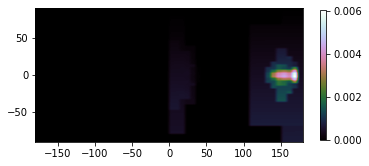

In [16]:
cm = plt.imshow(integratedI[:,:,0], extent=[-180, 180, -90, 90], cmap='cubehelix')
cb = plt.colorbar(cm, shrink=0.6)

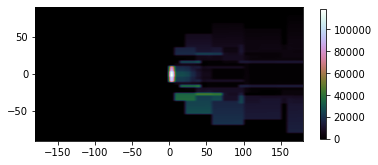

In [17]:
cm = plt.imshow(integratedI[:,:,23], extent=[-180, 180, -90, 90], cmap='cubehelix')
cb = plt.colorbar(cm, shrink=0.6)